In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import numpy as np
import scipy.sparse as ss
import pandas as pd
import sys
sys.path.append('..')
from os.path import join as pjoin

from gensim.models import Word2Vec

import keras.backend as K
from keras.callbacks import TensorBoard, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# from imblearn.over_sampling import ADASYN, SMOTE
# from imblearn.combine import SMOTEENN

# from textblob import TextBlob
# import spacy

from ipywidgets import IntProgress

from tst.preprocess.corpus import CorpusStreamer
from tst.io import AUTHORS, GB_DOCS, W2V
from tst.preprocess.transformers import TextCleaner
from tst.preprocess.w2v_extensions import *
from tst.evaluation.evaluate import sample_sentences
%matplotlib inline

c:\users\kevin\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
def pad(arr, n):
    if arr.shape[0] >= n:
        return arr[:n]
    else:
        return np.concatenate([arr, np.zeros((n-arr.shape[0], arr.shape[1]))])


def reshape(samples):
    return np.array(list(samples))
#     return (sample.reshape(sample.shape[0], -1) for sample in samples)

def custom_split(string):
    return re.findall(r'<?[\w]+>?|\S{1}', string)

def get_word_vector(word, wv):
    try:
        return wv[word]
    except:
        try:
            return wv["<unknown>"]
        except:
            return wv["desconocido"]

def tokens_to_wv(tokens, wv):
    return np.array(list(map(lambda x: get_word_vector(x, wv), tokens)))
 
def clean_txt(txt):
    txt = re.sub("[^A-Za-z!?' ]","*", txt)
    txt = re.sub("(\r?\n)+"," ", txt)
    txt = re.sub(" +"," ", txt)
    return txt

def ngram_tfidf(docs, ngram_range=(1,4), max_features=None, binary=False, use_idf=False, stop_words="english", stem=False, analyzer="word"):
    Vectorizor = StemmedTfidfVectorizer if stem else TfidfVectorizer
    tfidfVec = Vectorizor(ngram_range=ngram_range, stop_words=stop_words, use_idf=use_idf, max_features=max_features, binary=binary, analyzer=analyzer)
    return tfidfVec.fit_transform(docs)

def sequence_tokenize(docs, vocab_size=100000):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
    tokenizer.fit_on_texts(docs)
    return tokenizer.texts_to_sequences(docs)

def train_val_test_split(X, y, val_size, test_size, limit_testset=-1):
    X_train, X_test, y_train, y_test = train_test_split(X[:limit_testset], y[:limit_testset], test_size=test_size, random_state=0, stratify=y[:limit_testset])
    if limit_testset > 0:
        X_train, y_train = concat((X_train, X[limit_testset:])), concat((y_train, y[limit_testset:]))
    
    if val_size:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size*(1/(1-test_size)), random_state=0, stratify=y_train)
    else:
        X_val, y_val = np.array([]),np.array([])
        
    print("Train: {}, Val: {}, Test: {}".format(len(y_train), len(y_val), len(y_test)))
    return X_train, y_train, X_val, y_val, X_test, y_test

def train_keras_model(model, epochs, batch_size, X_train, y_train, X_val, y_val):
    K.clear_session()
    if "function" in str(type(model)):
        model = model(X_train)
    
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=1)
#             callbacks=[
#                 TQDMNotebookCallback(leave_inner=True),
#                 #TensorBoard('./tensorboard/')
#                 #EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#             ])
    return model

def evaluate_model(clf, X_test, y_test):
    y_pred = np.round(clf.predict(X_test))
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))


# class StemmedTfidfVectorizer(TfidfVectorizer):
#     english_stemmer = Stemmer.Stemmer('en')
    
#     def build_analyzer(self):
#         analyzer = super().build_analyzer()
#         return lambda doc: self.english_stemmer.stemWords(analyzer(doc))
    
def apply(function, per_row=True, **kwargs):
    def _apply(series):
        if per_row:
            return series.apply(function, **kwargs)
        else:
            return function(series, **kwargs)
    return _apply

def pipe(X, pipe):
    for name, f in pipe:
        print("Pipe: {}".format(name))
        X = f(X)
    return X

def concat(arrays):
    if "numpy.ndarray" in str(type(arrays[0])):
        return np.concatenate(arrays)
    elif "scipy.sparse" in str(type(arrays[0])):
        return ss.vstack(arrays)
    elif "pandas.core" in str(type(arrays[0])):
        return pd.concat(arrays)
    else:
        raise AttributeError

def plot_confusion_matrix(cm,
                          target_names = None,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
from keras.layers import Dense, Embedding, LSTM, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, Input, MaxPooling1D, concatenate, Dropout
from keras import Model, Sequential

def dense(X_train):
    model = Sequential()
    model.add(Dense(500, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

def gap_model(X_train):
    model = Sequential()
    model.add(Embedding(-1, 32))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

def conv_rnn_model(X_train):
    model = Sequential()
    model.add(Embedding(embedding.input_dim, embedding.output_dim, weights=embedding.get_weights()))
    model.add(Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50))
    model.add(Dense(1, activation="sigmoid"))
    return model

def rnn_model(X_train):
    model = Sequential()
    model.add(Embedding(-1, 16))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    return model

def zhang_cnn(X_train):
    # Zhang 2018a
    # https://arxiv.org/pdf/1803.03662.pdf
    n_filters = 100

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2], ))
    embedding = inputs
    #inputs = Input(shape=(X_train.shape[1], ))
    #embedding = Embedding(input_dim=10000, output_dim=200, input_length=X_train.shape[1], embeddings_initializer="random_uniform")(inputs)
    c1 = Conv1D(filters=n_filters, kernel_size=2, strides=1, padding='same', activation='relu')(embedding)
    c1 = MaxPooling1D(pool_size=4, strides=4)(c1)
    c2 = Conv1D(filters=n_filters, kernel_size=3, strides=1, padding='same', activation='relu')(embedding)
    c2 = MaxPooling1D(pool_size=4, strides=4)(c2)
    c3 = Conv1D(filters=n_filters, kernel_size=4, strides=1, padding='same', activation='relu')(embedding)
    c3 = MaxPooling1D(pool_size=4, strides=4)(c3)

    c4 = Conv1D(filters=n_filters, kernel_size=2, strides=1, padding='same', activation='relu', dilation_rate=2)(embedding)
    c4 = MaxPooling1D(pool_size=4, strides=4)(c4)
    c5 = Conv1D(filters=n_filters, kernel_size=2, strides=1, padding='same', activation='relu', dilation_rate=3)(embedding)
    c5 = MaxPooling1D(pool_size=4, strides=4)(c5)

    x = concatenate([c1,c2,c3,c4,c5], axis=1)
    x = GlobalMaxPooling1D()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def zhang_cnn_nodil(X_train):
    # Zhang 2018a
    # https://arxiv.org/pdf/1803.03662.pdf
    n_filters = 100

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2], ))
    embedding = inputs
    #inputs = Input(shape=(X_train.shape[1], ))
    #embedding = Embedding(input_dim=10000, output_dim=200, input_length=X_train.shape[1], embeddings_initializer="random_uniform")(inputs)
    c1 = Conv1D(filters=n_filters, kernel_size=2, strides=1, padding='same', activation='relu')(embedding)
    c1 = MaxPooling1D(pool_size=4, strides=4)(c1)
    c2 = Conv1D(filters=n_filters, kernel_size=3, strides=1, padding='same', activation='relu')(embedding)
    c2 = MaxPooling1D(pool_size=4, strides=4)(c2)
    c3 = Conv1D(filters=n_filters, kernel_size=4, strides=1, padding='same', activation='relu')(embedding)
    c3 = MaxPooling1D(pool_size=4, strides=4)(c3)

    x = concatenate([c1,c2,c3], axis=1)
    x = GlobalMaxPooling1D()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def zhang_gru_cnn(X_train):
    # Zhang 2018a
    # https://arxiv.org/pdf/1803.03662.pdf
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2],))

    c1 = Conv1D(filters=100, kernel_size=2, strides=1, padding='same', activation='relu')(inputs)
    c1 = MaxPooling1D(pool_size=4, strides=4)(c1)
    c2 = Conv1D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    c2 = MaxPooling1D(pool_size=4, strides=4)(c2)
    c3 = Conv1D(filters=100, kernel_size=4, strides=1, padding='same', activation='relu')(inputs)
    c3 = MaxPooling1D(pool_size=4, strides=4)(c3)
    x = concatenate([c1,c2,c3], axis=1)
    x = GRU(100, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def zhang_gru_cnn_small(X_train):
    # Zhang 2018b
    # https://www.researchgate.net/profile/Ziqi_Zhang7/publication/325529410_Detecting_Hate_Speech_on_Twitter_Using_a_Convolution-GRU_Based_Deep_Neural_Network/links/5b1e321eaca272021cf59b29/Detecting-Hate-Speech-on-Twitter-Using-a-Convolution-GRU-Based-Deep-Neural-Network.pdf
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2],))
    x = Dropout(.2)(inputs)

    x = Conv1D(filters=100, kernel_size=4, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=4, strides=4)(x)
    x = GRU(100, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
emb = Word2Vec.load(W2V)

In [7]:
author = 'wells'
sample_size = 20000

data = []
data.extend([{'author': 1, 'text': s} for s in sample_sentences(sample_size, pjoin(AUTHORS, author, 'books'))])
data.extend([{'author': 0, 'text': s} for s in sample_sentences(sample_size, GB_DOCS)])

df = pd.DataFrame(data).drop_duplicates()

In [8]:
glove_pipe = [
    ("clean", apply(TextCleaner().fit_transform)),
    ("vectorizing", apply(emb.wv.vectorize, flatten=True)),
    ("padding", apply(pad, n=50))
    ,("reshape", apply(reshape, False))
    ,("train_test_split", apply(train_val_test_split, False, y=df['author'], val_size=0.1, test_size=.1, limit_testset=len(df)))
]

In [50]:
df.drop(35348, inplace=True)

In [43]:
x[x.apply(np.shape).apply(len) == 1]

35348    []
Name: text, dtype: object

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = pipe(df.text, glove_pipe)

Pipe: clean
Pipe: vectorizing
Pipe: padding
Pipe: reshape
Pipe: train_test_split
Train: 30191, Val: 3774, Test: 3774


Train on 30191 samples, validate on 3774 samples
Epoch 1/6
30191/30191 [==============================] - 11s 348us/step - loss: 0.8445 - acc: 0.6094 - val_loss: 0.7070 - val_acc: 0.6545
Epoch 2/6
30191/30191 [==============================] - 8s 277us/step - loss: 0.5867 - acc: 0.7158 - val_loss: 0.7080 - val_acc: 0.6577
Epoch 3/6
30191/30191 [==============================] - 8s 277us/step - loss: 0.4931 - acc: 0.7616 - val_loss: 0.6897 - val_acc: 0.6757
Epoch 4/6
30191/30191 [==============================] - 8s 277us/step - loss: 0.4287 - acc: 0.8042 - val_loss: 0.6920 - val_acc: 0.6831
Epoch 5/6
30191/30191 [==============================] - 8s 277us/step - loss: 0.3758 - acc: 0.8298 - val_loss: 0.7370 - val_acc: 0.6717
Epoch 6/6
30191/30191 [==============================] - 8s 278us/step - loss: 0.3173 - acc: 0.8630 - val_loss: 0.7518 - val_acc: 0.6834
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1995
           1       

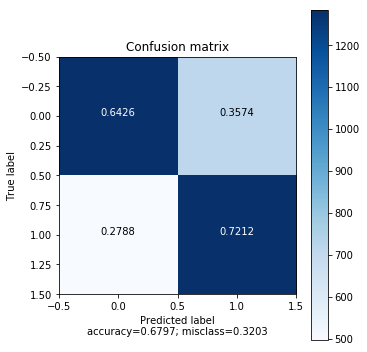

In [10]:
clf = train_keras_model(zhang_cnn, 6, 32, X_train, y_train, X_val, y_val)
evaluate_model(clf, X_test, y_test)

In [11]:
clf.save(pjoin(AUTHORS, author, 'parsed', 'clf.h5'))

In [42]:
from keras.models import load_model
from tst.preprocess.helper import nlp

In [36]:
model = load_model(pjoin(AUTHORS, author, 'parsed', 'clf.h5'))

In [30]:
predict('This is a test.', model, emb.wv)

0.3991792

In [49]:
aemb = KeyedVectors.load_word2vec_format(pjoin(AUTHORS, 'churchill', 'parsed', 'only.vec'))
print(len(aemb.vocab))
doc = nlp()(' '.join(aemb.vocab.keys()))
print(len(set((w.lemma_ for w in doc))))

41129
26876
